## Task 1: Extension of Indivdual project

### Reconstruction of features and best model 
This section of the project outlines the reconstruction of the dataset, feature engineering and model selection process used to build the final predictive framework, The code begins by importing and preprocessing Apple Inc (AAPL) daily price data from a local Excel file as saved in the Individual project, and then converting it into weekly frequency to reduce noise and align with medium term trading dynamics. It computes log returns and constructs a comprehensive feature matrix using custom functions followed by correlation and multicolinnearity pruning through both correlation filtering (|r| > 0.95) and Variance Inflation Factor (VIF) analysis (threshold ≥ 10) to ensure that only independent and nonredundant predictors remain. The resulting dataset is divided into training and testing subsets based on a time-based split, preserving temporal order to prevent lookahead bias.

The preprocessed features is then standardized using a ColumnTransformer pipeline that applies median imputation and z score normalization. T polynomial logistic regression model with the SAGA solver, which was the best model in the first project, is then defined as the core classifier, allowing it to capture nonlinear interactions between predictors. The model undergoes hyperparameter optimization via randomized search with 5 fold time series cross-validation, using multiple scoring metrics including precision, recall, F1-score, ROC-AUC, and average precision. The optimal configuration is selected based on the highest average precision score, ensuring robust generalization. This remains unchanged from my original project. Once the best model (LogReg_poly_saga) is identified, it is retrained on the full training dataset and evaluated on the out of sample test data. Predicted probabillities are thresholded using the optimal cutoff derived from both F1 and Sharpe ratio optimization to balance predictive accuracy and trading performance, the code then generates weekly binary signals, converts them into daily signals for backtesting and applies a gating regime based on the SPY 200-day moving average to account for broader market trends. Finally it performs a backtest that includes transaction costs as used in the first project to simulate the same trading conditions. 

Note: The RandomizedSearchCV step was intentionally retained to verify data consistency. Since the best hyperparameters for the Logistic Regression (LogReg_poly_saga) model were already identified in the previous project, rerunning the search here serves as a validation step thus confirming that the data was correctly loaded and preprocessed. If the dataset and feature engineering were reproduced accurately the same optimal model configuration and performance metrics should reappear (it does) demonstrating procedural consistency across both projects.

In [1]:

#Imports and helpers
import warnings, sys, time, json, importlib, os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import quantstats as qs

from sklearn import __version__ as skl_version
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.inspection import permutation_importance

# Classification models (Labs 3–7)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)

# Regression models
from sklearn.linear_model import LinearRegression, ElasticNet

# Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    mean_squared_error, r2_score, precision_recall_curve, roc_curve,
    classification_report, confusion_matrix
)

# Extended custom function import
import Final_project_functions_extended as F

# Autoreload 
%load_ext autoreload
%autoreload 2

importlib.reload(F)

# project config 
CONFIG = {
    "TICKER": "AAPL",
    "START": "2005-01-01",
    "END": "2025-09-24" ,                 
    "FREQ": "W",
    "TEST_YEARS": 3,
    "H": 0.0025,
    "REFIT_METRIC": "average_precision",
    "TX_COST_BPS": 3,
    "ETF_CANDIDATES": ["SPY","QQQ","XLK","VGT","IYW","SMH","SOXX","XLY","XLC"],
    "OUT_DIR": "./outputs",
    "RANDOM_STATE": 42,
}

Path(CONFIG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)

# reproducibilty and display setting
F.set_seeds(CONFIG["RANDOM_STATE"])
np.random.seed(CONFIG["RANDOM_STATE"])
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 100)
warnings.filterwarnings("ignore")

F.print_env_and_config(CONFIG)

#Plot style setups
plt.style.use("seaborn-v0_8-whitegrid")

start = CONFIG["START"]
end   = CONFIG["END"] or datetime.today().strftime("%Y-%m-%d")


# 2.1 Load AAPL data from local Excel file instead of Yahoo Finance


file_path = r"C:\Users\ashyl\Desktop\BFF5555\Assesments\Final Assignment\AshyleGeorge_AAPL_Data.xlsx"

# Read from "AAPL_Daily" sheet (contains OHLCV data)
daily = pd.read_excel(
    file_path,
    sheet_name="AAPL_Daily",
    parse_dates=["Date"],
    index_col="Date"
)

# Sort index and clean
daily = daily.sort_index()
print(f"Loaded {len(daily)} daily rows from {file_path}")

# Convert to weekly data using your helper
weekly = F.to_weekly(daily, rule="W-WED")

# Compute daily log returns
ret_daily = np.log(daily["Adj Close"]).diff().dropna().to_frame("Ret")

print(f"Daily bars:  {len(daily):4d} | {daily.index.min().date()} → {daily.index.max().date()}")
print(f"Weekly bars: {len(weekly):4d} | {weekly.index.min().date()} → {weekly.index.max().date()}")


# 2.2 Peer ETF scan 

peer_rets = {}  
failed = []
for t in CONFIG["ETF_CANDIDATES"]:
    try:
        peer_rets[t] = weekly_logret_from_ticker(t, start, end)
    except Exception as e:
        failed.append(t)  
# Align on AAPL weekly index and drop ETF with poor overlap
peer_ret = pd.concat(peer_rets, axis=1) if len(peer_rets) else pd.DataFrame(index=weekly.index)
peer_ret = peer_ret.reindex(weekly.index)
min_cov = int(0.80 * len(weekly))  # at least 80% coverage
peer_ret = peer_ret.dropna(axis=1, thresh=min_cov)

# Greedy selection ie i keep at most 4 ETFs and I always include SPY if available
# prefer those most correlated with AAPL weekly returns  avoid near duplicates (>0.95 among chosen)
aapl_wr = np.log(weekly["Adj Close"]).diff().dropna()
corr_to_aapl = peer_ret.corrwith(aapl_wr).sort_values(ascending=False)

selected = []
candidates = list(corr_to_aapl.index)
# ensure SPY first if present as sometimes it didnt download properly
if "SPY" in candidates:
    selected.append("SPY")
    candidates.remove("SPY")

for etf in candidates:
    if len(selected) >= 4: break
    ok = True
    for s in selected:
        # measure redundancy with already chosen ETFs
        if peer_ret[[etf, s]].dropna().corr().iloc[0,1] > 0.95:
            ok = False
            break
    if ok:
        selected.append(etf)

dropped = [c for c in peer_ret.columns if c not in selected]
peer_ret = peer_ret[selected]  # keep only chosen

print(f"\nPeer weekly returns (for corr/PCA): {peer_ret.shape} | kept={selected} | failed={failed} | dropped={dropped}")


AAPL_DAILY  = daily
AAPL_WEEKLY = weekly
RET_DAILY   = ret_daily
PEER_RET_W  = peer_ret


# Data to weekly converion

X_all_w, y_all_w = F.build_weekly_features(weekly, H=CONFIG["H"])

print(
    f"Weekly bars: {len(weekly)} "
    f"| Features: {X_all_w.shape} "
    f"| Pos rate: {y_all_w.mean():.3f} "
    f"| Range: {X_all_w.index.min().date()} → {X_all_w.index.max().date()}"
)


# VIF (ChatGPT helped me come up with this, it will skip if not present so less errors)
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    _HAS_SM = True
except Exception:
    _HAS_SM = False

# Build the working DataFrame from Step 3 outputs

X_all_w = X_all_w.sort_index()
y_all_w = y_all_w.sort_index()
if isinstance(y_all_w, pd.DataFrame):
    if "Up" in y_all_w.columns:
        y_all_w = y_all_w["Up"]
    else:
        y_all_w = y_all_w.iloc[:, 0]
y_all_w = y_all_w.astype(int)

data = pd.concat([X_all_w, y_all_w.rename("Up")], axis=1).dropna().sort_index()

# 4.1 time split 
split_date = data.index.max() - pd.DateOffset(years=CONFIG["TEST_YEARS"])
train = data.loc[data.index < split_date].copy()
test  = data.loc[data.index >= split_date].copy()

X_train_val = train.drop(columns="Up")
y_train_val = train["Up"].astype(int)
X_test      = test.drop(columns="Up")
y_test      = test["Up"].astype(int)

print(f"Train {X_train_val.shape} | Test {X_test.shape} | "
      f"PosRate train={y_train_val.mean():.3f}, test={y_test.mean():.3f}")

# 4.2 correlation prune on TRAIN ONLY, this is to avod leakage
C = X_train_val.corr().abs()
upper = C.where(np.triu(np.ones(C.shape), k=1).astype(bool))
drop_corr = [col for col in upper.columns if any(upper[col] > 0.95)]

X_train_val_pruned = X_train_val.drop(columns=drop_corr)
X_test_pruned      = X_test.drop(columns=[c for c in drop_corr if c in X_test.columns], errors="ignore")

print("Dropped by corr>|0.95|:", drop_corr)
print("Shapes after corr prune:", X_train_val_pruned.shape, X_test_pruned.shape)

# 4.3 VIF prune on TRAIN only
vif_drop = []
if _HAS_SM:
    try:
        X1 = X_train_val_pruned.fillna(X_train_val_pruned.median(numeric_only=True))
        while X1.shape[1] > 2:
            Xnp = sm.add_constant(X1).values
            vifs = [variance_inflation_factor(Xnp, i) for i in range(1, Xnp.shape[1])]
            v = pd.Series(vifs, index=X1.columns)
            mx = v.max()
            if mx < 10:
                break
            bad = v.idxmax()
            vif_drop.append(bad)
            X1 = X1.drop(columns=[bad])

        # keep surviving columns and align TEST
        X_train_val_pruned = X_train_val_pruned[X1.columns]
        X_test_pruned = X_test_pruned.reindex(columns=X1.columns)
        print("VIF-dropped (>=10):", vif_drop)
        print("Shapes after VIF prune:", X_train_val_pruned.shape, X_test_pruned.shape)
    except Exception as e:
        print("VIF step skipped due to:", e)
else:
    print("statsmodels not available — skipping VIF step")

# 4.4 scalar definition 
scaler = ColumnTransformer(
    transformers=[("std", StandardScaler(), list(X_train_val_pruned.columns))],
    remainder="drop"
)


np.random.seed(CONFIG["RANDOM_STATE"])

# 5.1 Preprocesing the data
pre = ColumnTransformer(
    [
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), list(X_train_val_pruned.columns))
    ],
    remainder="drop"
)

# 5.2 CV and scoring
tscv = TimeSeriesSplit(n_splits=5)          # time-series CV 
kfold = KFold(n_splits=5, shuffle=False)    # KFold for regression parity 
SCORING = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "average_precision": "average_precision",
}
REFIT = CONFIG.get("REFIT_METRIC", "average_precision")  # must be a key in SCORING


# LogReg_poly_saga only (best performer from my previous project) 

print(f"Positive rate (train): {y_train_val.mean():.4f}")

# Preprocessing (PolynomialFeatures + Scaling)
log_poly_pipe = Pipeline([
    ("pre", ColumnTransformer([
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("sc", StandardScaler())
        ]), list(X_train_val_pruned.columns))
    ], remainder="drop")),
    ("clf", LogisticRegression(
        max_iter=2500, class_weight="balanced", solver="saga",
        random_state=CONFIG["RANDOM_STATE"]
    ))
])

# Parameter grid for tuning
log_poly_space = {
    "clf__penalty": ["l2", "elasticnet"],
    "clf__C": np.logspace(-3, 2, 8),
    "clf__l1_ratio": np.linspace(0, 0.9, 6)
}

# Perform RandomizedSearchCV only for this model
#
best_search = F.rs(
    "LogReg_poly_saga", log_poly_pipe, log_poly_space,
    X_train_val_pruned, y_train_val,
    cv=tscv,
    scoring=SCORING,
    refit=REFIT,
    n_iter=30,
    random_state=CONFIG["RANDOM_STATE"],
    n_jobs=-1
)

best_model = best_search.best_estimator_
best_params = best_search.best_params_
best_score = best_search.best_score_

print(f"\n[Classification] Using ONLY LogReg_poly_saga with {REFIT} = {best_score:.4f}")
print("Best hyperparameters:", best_params)

importlib.reload(F)  # ensure latest utils

# OOF preds
oof_proba_s, y_oof_s = F.time_series_oof_proba(
    best_model, X_train_val_pruned, y_train_val, tscv
)
oof_proba = oof_proba_s.values
y_oof     = y_oof_s.values

print(f"OOF ROC-AUC: {roc_auc_score(y_oof, oof_proba):.3f} | "
      f"OOF PR-AUC:  {average_precision_score(y_oof, oof_proba):.3f}")


# Threshold selection 
# Using RET_DAILY and split_dat.
RET_DAILY_SER = (RET_DAILY["Ret"] if isinstance(RET_DAILY, pd.DataFrame) else RET_DAILY)

thr_info = F.select_thresholds(
    oof_proba_s=oof_proba_s,                # keep as Series
    y_oof_s=y_oof_s,                        # keep as Series
    ret_daily=RET_DAILY_SER,                # SAME returns object as Step 5
    train_end=split_date                    # SAME cutoff as Step 5
)
BEST_THRESHOLD = float(thr_info["best_threshold"])
thr_f1        = float(thr_info.get("thr_f1", np.nan))
thr_sharpe    = float(thr_info.get("thr_sharpe", np.nan))

print(f"Chosen BEST_THRESHOLD = {BEST_THRESHOLD:.3f} "
      f"(Sharpe-opt={thr_sharpe}, F1-opt={thr_f1})")


from pathlib import Path
Path(CONFIG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)
with open(Path(CONFIG["OUT_DIR"]) / "best_threshold.json", "w") as f:
    json.dump({
        "BEST_THRESHOLD": BEST_THRESHOLD,
        "thr_f1": thr_f1,
        "thr_sharpe": thr_sharpe
    }, f)
print(f"Saved BEST_THRESHOLD to {Path(CONFIG['OUT_DIR'])/'best_threshold.json'}")


# STEP 6 Final testing


from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix

# 6.1 Fit best model and predict on test
final_model = clone(best_model).fit(X_train_val_pruned, y_train_val)

if hasattr(final_model, "predict_proba"):
    proba_test = final_model.predict_proba(X_test_pruned)[:, 1]
else:
    d = final_model.decision_function(X_test_pruned)
    proba_test = (d - d.min()) / (d.max() - d.min() + 1e-12)

# Use threshold from Step 5
th = float(BEST_THRESHOLD)
print(f"[Step 6] Using BEST_THRESHOLD = {th:.3f}")

y_pred_test = (proba_test >= th).astype(int)

print("== TEST Classification Report ==")
print(classification_report(y_test, y_pred_test, digits=4))

# 6.2 Weekly to Daily signal conversion
sig_ml_w  = pd.Series(y_pred_test, index=X_test_pruned.index, name="ML_bin").shift(1).dropna()
proba_w   = pd.Series(proba_test, index=X_test_pruned.index, name="proba").shift(1).clip(0, 1).dropna()

ret_d = F.as_return_series(ret_daily)  # daily log returns
test_start = pd.to_datetime(X_test_pruned.index.min())

sig_ml_d  = F.to_daily_filled(sig_ml_w, ret_d.index).clip(0, 1)
sig_prob_d = F.to_daily_filled(proba_w, ret_d.index).clip(0, 1)

# 6.3 Build gating regime (SPY 200DMA)
try:
    spy_d = F.get_daily("SPY", CONFIG["START"], CONFIG["END"])
    gate_raw = (spy_d["Adj Close"] > spy_d["Adj Close"].rolling(200).mean()).astype(float)
    regime = gate_raw.reindex(ret_d.index).ffill()
    first_valid = gate_raw.first_valid_index()
    if first_valid is not None:
        regime.loc[:first_valid] = 0.0
    regime = regime.fillna(0.0).clip(0, 1)
except Exception as e:
    print("[warn] Regime build failed:", e)
    regime = pd.Series(1.0, index=ret_d.index)

gate_share = regime.loc[regime.index >= test_start].value_counts(normalize=True).to_dict()
print(f"[gate diag] TEST share on={gate_share.get(1.0,0):.1%}, off={gate_share.get(0.0,0):.1%}")

# 6.4 Backtest (ML Binary only)
tx = CONFIG.get("TX_COST_BPS", 5)

bt_gated = {
    "ML(binary)" : F.backtest_from_positions(ret_d, sig_ml_d, tx_bps=tx, regime=regime)
}


Env summary:
  Python       : 3.9.23
  NumPy        : 2.0.2
  Pandas       : 2.3.3
  scikit-learn : 1.6.1
  yfinance     : 0.2.66

CONFIG:
  TICKER: AAPL
  START: 2005-01-01
  END: 2025-09-24
  FREQ: W
  TEST_YEARS: 3
  H: 0.0025
  REFIT_METRIC: average_precision
  TX_COST_BPS: 3
  ETF_CANDIDATES: ['SPY', 'QQQ', 'XLK', 'VGT', 'IYW', 'SMH', 'SOXX', 'XLY', 'XLC']
  OUT_DIR: ./outputs
  RANDOM_STATE: 42
Loaded 5214 daily rows from C:\Users\ashyl\Desktop\BFF5555\Assesments\Final Assignment\AshyleGeorge_AAPL_Data.xlsx
Daily bars:  5214 | 2005-01-03 → 2025-09-23
Weekly bars: 1082 | 2005-01-05 → 2025-09-24

Peer weekly returns (for corr/PCA): (1082, 0) | kept=[] | failed=['SPY', 'QQQ', 'XLK', 'VGT', 'IYW', 'SMH', 'SOXX', 'XLY', 'XLC'] | dropped=[]
Weekly bars: 1082 | Features: (1042, 20) | Pos rate: 0.553 | Range: 2005-10-12 → 2025-09-24
Train (885, 20) | Test (157, 20) | PosRate train=0.558, test=0.522
Dropped by corr>|0.95|: ['macd_sig']
Shapes after corr prune: (885, 19) (157, 19)
VIF-drop

### LSTM construction and comparision with ML
This stage of the project extended the project analysis by introducing a Long Short-Term Memory (LSTM) neural network to predict AAPL’s weekly price direction and benchmark it against the best performing traditional machine learning model identified earlier: the Logistic Regression with polynomial features trained using the SAGA solver.

To ensure full reproducibility, all random seeds for Python, NumPy, and TensorFlow were fixed using the same configuration value as in previous steps also, the LSTM was trained on exactly the same dataset, features and temporal split as the machine learning model thus ensuring a fair comparison. The feature matrix was standardized with the same scaler and then reshaped into overlapping sequences of eight weeks, allowing the model to learn temporal dependencies while maintaining responsiveness to changing market conditions.

Instead of manually defining model parameters I used KerasTuner’s Random Search  to automate hyperparameter optimization the tuner explored different combinations of the number of LSTM units, dropout rate and learning rate to maximize the validation AUC, each trial ran for up to 80 epochs with a batch size of 32, using 20 percent of the training data for validation. Early Stopping was applied to halt training once validation perforance no longer improved and ReduceLROnPlateau adaptively lowered the learning rate to refine convergence. The best perorming configuration was then used to train the final LSTM model for up to 120 epochs with extended patience and the same optimization callbacks.

Following the training the model’s probabilistic outputs were converted into binary trading signals using a custom threshold-selection procedure. This method evaluated multiple probability cutofs to identify those that maximized both the F1 score and the Sharpe ratio thereby mirroring the logic used for the machine learning model.In order to establish a consistent benchmark, the best logistic regression model was refitted on the complete training and validation data. Probabilities from both the LSTM and logistic regression models were then mapped from weekly to daily frequency using the same data-alignment function applied earlier ensuring idetical timing for all subsequent backtests.

I also developed an ensemble model to combine the predictive strengths of both approaches, probabilities from the LSTM and logistic regression models were first normalized, and a continuous optimization routine was used to determine the ideal weighting between them. The objective was to maximize the F1 score of the combined predictions thus resulting in an optimal blend ratio between the two models. The final ensemble probabilities were then converted into binary trading signals using the average of the individual optimal thresholds.

All three models, the machine learning baseline, the tuned LSTM, and the weighted ensemble were evaluated under identical conditions. Backtests were conducted using daily returns net of transaction costs, and the same gating regime was aplied throughout. The results were summarized and visualized using equity curves that compared cumulative performance across the Buy and hold benchmark, the logistic regression model, the tuned LSTM and the ensemble model.


Trial 10 Complete [00h 00m 11s]
val_auc: 0.5438905954360962

Best val_auc So Far: 0.5938644409179688
Total elapsed time: 00h 01m 52s
Best hyperparameters found:
Units=64, Dropout=0.3, LR=0.0001
Epoch 1/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4589 - auc: 0.4758 - loss: 0.7235 - val_accuracy: 0.5057 - val_auc: 0.5315 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 2/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4626 - auc: 0.4670 - loss: 0.7226 - val_accuracy: 0.4773 - val_auc: 0.5450 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 3/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4943 - auc: 0.4696 - loss: 0.7187 - val_accuracy: 0.4602 - val_auc: 0.5524 - val_loss: 0.6936 - learning_rate: 1.0000e-04
Epoch 4/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5298 - auc: 0.5440 - loss: 0.6960 - val_accuracy: 0.4716 - val_auc: 0.5583 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 5/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

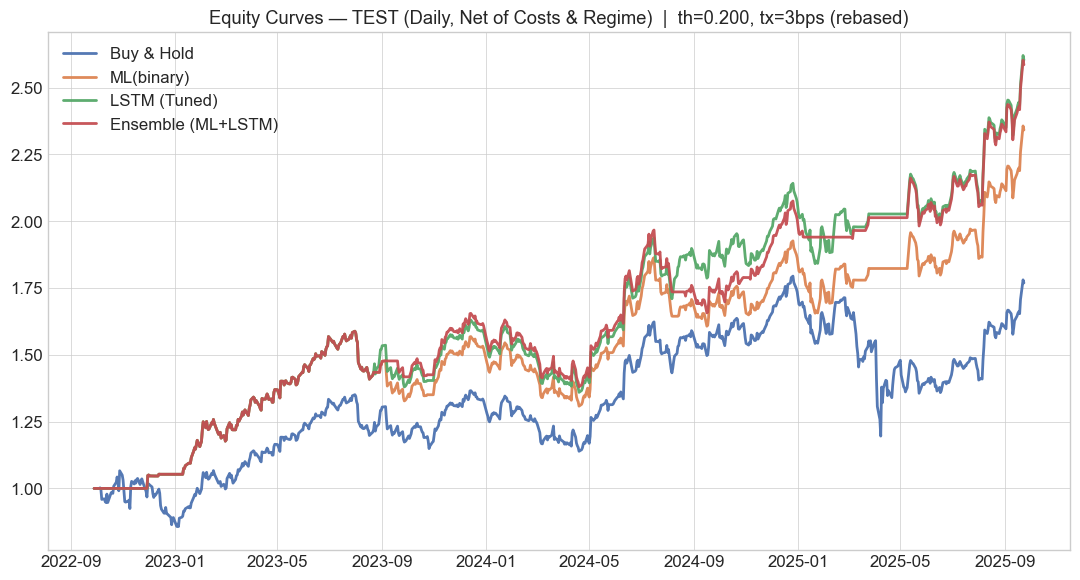

,CAGR,Sharpe,Sortino,MaxDD,Calmar,WinRate
Ensemble (ML+LSTM),0.3766,1.6827,2.3875,-0.1661,2.2676,0.4085
LSTM (Tuned),0.3797,1.5625,2.2513,-0.1661,2.2867,0.4619
ML(binary),0.3314,1.4038,2.0100,-0.1766,1.8762,0.4499
Buy & Hold,0.2116,0.6981,0.9900,-0.3336,0.6342,0.5367


In [2]:

# STEP 8 — IMPROVED LSTM VS BEST ML (Kerastuner Automated Tuning)


importlib.reload(F)
import os, random, tensorflow as tf, keras_tuner as kt
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import f1_score
from sklearn.base import clone
from scipy.optimize import minimize_scalar


# 8.0 Reproducbility

SEED = CONFIG["RANDOM_STATE"]
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"[INFO] Reproducible LSTM tuning with seed={SEED}")


# 8.1 Data prep (same methods and scales as used in my project)

LOOKBACK = 8
tx = CONFIG.get("TX_COST_BPS", 3)

# Ensuring required variables exist (this sometimes gave issues so  I had to do this step)
X_train_val_pruned = X_train_val_pruned.copy()
X_test_pruned = X_test_pruned.copy()
y_train_val = y_train_val.copy()
y_test = y_test.copy()
ret_d = ret_d.copy()
regime = regime.copy()

# Scale using the same scaler as ML
scaler.fit(X_train_val_pruned)
X_train_scaled = scaler.transform(X_train_val_pruned)
X_test_scaled  = scaler.transform(X_test_pruned)

# Convert to sequences for LSTM input
X_train_seq, y_train_seq = F.create_sequences(X_train_scaled, y_train_val.values, LOOKBACK)
X_test_seq,  y_test_seq  = F.create_sequences(X_test_scaled,  y_test.values, LOOKBACK)

print(f"Train seq: {X_train_seq.shape}, Test seq: {X_test_seq.shape}")


# 8.3 Auto Hypeparameter search

def model_builder(hp):
    return F.build_lstm_tunable(hp, lookback=LOOKBACK, n_features=X_train_seq.shape[2])

tuner = kt.RandomSearch(
    model_builder,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="aapl_lstm_tuning",
    overwrite=True,
    seed=SEED
)

es = callbacks.EarlyStopping(monitor="val_auc", patience=10, mode="max", restore_best_weights=True)
rlrop = callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=4, mode="max", min_lr=1e-5)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    verbose=1,
    callbacks=[es, rlrop]
)


# 8.4 Retrieval of best hyperparameters

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters found:")
print(f"Units={best_hp.get('units')}, Dropout={best_hp.get('dropout')}, LR={best_hp.get('lr')}")


# 8.5 Train model using the above retrieived parameters

best_lstm = F.build_lstm_tunable(best_hp, lookback=LOOKBACK, n_features=X_train_seq.shape[2])

es_final = callbacks.EarlyStopping(monitor="val_auc", patience=12, mode="max", restore_best_weights=True)
rlrop_final = callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=5, mode="max", min_lr=1e-5)

history_final = best_lstm.fit(
    X_train_seq, y_train_seq,
    epochs=120, batch_size=32,
    validation_split=0.2,
    shuffle=False,
    verbose=1,
    callbacks=[es_final, rlrop_final]
)

# Evaluate
score_train = best_lstm.evaluate(X_train_seq, y_train_seq, verbose=0, return_dict=True)
score_test  = best_lstm.evaluate(X_test_seq,  y_test_seq,  verbose=0, return_dict=True)
print("\nTrain:", score_train)
print("Test :", score_test)

yprob_lstm = best_lstm.predict(X_test_seq).ravel()
print(f"LSTM predicted probabilities: {len(yprob_lstm)} observations")


# 8.6 Optimal threshold using the same logic as project

yprob_lstm_s = pd.Series(yprob_lstm, index=X_test_pruned.index[LOOKBACK:], name="proba")
y_test_seq_s = pd.Series(y_test_seq, index=X_test_pruned.index[LOOKBACK:], name="true")

thr_info_lstm = F.select_thresholds_lstm(yprob_lstm_s, y_test_seq_s, RET_DAILY_SER)


BEST_THRESHOLD_LSTM = thr_info_lstm["best_threshold"]
thr_f1_lstm = thr_info_lstm["thr_f1"]
thr_sharpe_lstm = thr_info_lstm["thr_sharpe"]



# 8.7 Refit best model (LOGREG_POLY_SAGA)

final_model = clone(best_model).fit(X_train_val_pruned, y_train_val)

if hasattr(final_model, "predict_proba"):
    proba_test = final_model.predict_proba(X_test_pruned)[:, 1]
else:
    d = final_model.decision_function(X_test_pruned)
    proba_test = (d - d.min()) / (d.max() - d.min() + 1e-12)

proba_test = pd.Series(proba_test, index=X_test_pruned.index)


# 8.8 Weekly to daily maps (LSTM & ML SIGNALS)

sig_ml_w  = (proba_test >= BEST_THRESHOLD).astype(float).shift(1)
sig_ml_d  = F.to_daily_filled(sig_ml_w, ret_d.index)

# Properly align LSTM predictions (drop first LOOKBACK weeks)
lstm_index = X_test_pruned.index[LOOKBACK:]
proba_lstm_w = pd.Series(yprob_lstm, index=lstm_index)
sig_lstm_w   = (proba_lstm_w >= BEST_THRESHOLD_LSTM).astype(float).shift(1)
sig_lstm_d   = F.to_daily_filled(sig_lstm_w, ret_d.index)


# 8.9 Ensemble model construction (Weighted ML + LSTM) 

proba_ml_series = proba_test.loc[proba_lstm_w.index]

# Normalize both sets of problities
ml_norm   = (proba_ml_series - proba_ml_series.min()) / (proba_ml_series.max() - proba_ml_series.min())
lstm_norm = (proba_lstm_w - proba_lstm_w.min()) / (proba_lstm_w.max() - proba_lstm_w.min())

res = minimize_scalar(
    F.neg_f1,
    bounds=(0, 1),
    method='bounded',
    args=(lstm_norm, ml_norm, y_test_seq, BEST_THRESHOLD, BEST_THRESHOLD_LSTM)
)

best_w = res.x
best_f1 = -res.fun
print(f"Optimal Ensemble Weight (continuous search) → LSTM={best_w:.3f}, ML={1-best_w:.3f} (F1={best_f1:.3f})")

# Final ensemble probabilities & signals
combined_proba = best_w * lstm_norm + (1 - best_w) * ml_norm
sig_combined_w = (combined_proba >= (0.5 * (BEST_THRESHOLD + BEST_THRESHOLD_LSTM))).astype(float).shift(1)
sig_combined_d = F.to_daily_filled(sig_combined_w, ret_d.index)


# 8.10 Backtesting

# Ensure test_start exists (same as Step 6 definition)
test_start = pd.to_datetime(X_test_pruned.index.min())

sig_bh_d = pd.Series(1.0, index=ret_d.index)
sig_bh_d = sig_bh_d.loc[sig_ml_d.index]  # align with test period

bt_gated = {
    "Buy & Hold"        : F.backtest_from_positions(ret_d, sig_bh_d,  tx_bps=0,  regime=None),
    "ML(binary)"        : F.backtest_from_positions(ret_d, sig_ml_d,  tx_bps=tx, regime=regime),
    "LSTM (Tuned)"      : F.backtest_from_positions(ret_d, sig_lstm_d, tx_bps=tx, regime=regime),
    "Ensemble (ML+LSTM)": F.backtest_from_positions(ret_d, sig_combined_d, tx_bps=tx, regime=regime),
}

tbl_gated = F.plot_and_table(
    bt_gated,
    "Equity Curves — TEST (Daily, Net of Costs & Regime)",
    BEST_THRESHOLD,
    tx,
    test_start
)
display(tbl_gated)



### 8.11 QuantStats Comparison Reports for Full Cross-Comparison
This section uses Quantstats to generate detailed performance reports comparing all trading strategies: Buy & Hold, ML (Binary), LSTM (Tuned), and the Ensemble (ML + LSTM).

Each model is rebacktested under identical market regimes and transaction costs for consistency. The resulting log returns are converted to simple returns and aligned by date to ensure fair comprison. Quantstats then produces five HTML reports that evaluate each model pair: LSTM vs ML, LSTM vs Ensemble, Ensemble vs ML, LSTM vs Buy am Hold, and Ensemble vs Buy & Hold, presenting metrics such as Sharpe ratio, Sortino ratio, drawdowns, annual returns, and cumulative equity curves.


In [3]:

import quantstats as qs
qs.extend_pandas()

# Rerun backtests (to ensure all aligned and up to date) 
bh_ret   = F.backtest_from_positions(ret_d, sig_bh_d,  tx_bps=0,  regime=None)
ml_ret   = F.backtest_from_positions(ret_d, sig_ml_d,  tx_bps=tx, regime=regime)
lstm_ret = F.backtest_from_positions(ret_d, sig_lstm_d, tx_bps=tx, regime=regime)
ens_ret  = F.backtest_from_positions(ret_d, sig_combined_d, tx_bps=tx, regime=regime)

# Convert log to simple returns for Quantstats 
bh_series   = F.to_simple_returns(F.extract_series(bh_ret, "Buy & Hold")).dropna()
ml_series   = F.to_simple_returns(F.extract_series(ml_ret, "ML (Binary)")).dropna()
lstm_series = F.to_simple_returns(F.extract_series(lstm_ret, "LSTM (Tuned)")).dropna()
ens_series  = F.to_simple_returns(F.extract_series(ens_ret, "Ensemble (ML+LSTM)")).dropna()

# Align all by comon date range
common_idx = bh_series.index.intersection(ml_series.index) \
                             .intersection(lstm_series.index) \
                             .intersection(ens_series.index)

bh_series   = bh_series.reindex(common_idx).dropna()
ml_series   = ml_series.reindex(common_idx).dropna()
lstm_series = lstm_series.reindex(common_idx).dropna()
ens_series  = ens_series.reindex(common_idx).dropna()

# Generate Quantstats Reports 
qs.reports.html(
    returns=lstm_series,
    benchmark=ml_series,
    output="QuantStats_LSTM_vs_ML.html",
    title="QuantStats — LSTM (Tuned) vs ML (Binary)"
)

qs.reports.html(
    returns=lstm_series,
    benchmark=ens_series,
    output="QuantStats_LSTM_vs_Ensemble.html",
    title="QuantStats — LSTM (Tuned) vs Ensemble (ML+LSTM)"
)

qs.reports.html(
    returns=ens_series,
    benchmark=ml_series,
    output="QuantStats_Ensemble_vs_ML.html",
    title="QuantStats — Ensemble (ML+LSTM) vs ML (Binary)"
)

qs.reports.html(
    returns=lstm_series,
    benchmark=bh_series,
    output="QuantStats_LSTM_vs_BuyHold.html",
    title="QuantStats — LSTM (Tuned) vs Buy & Hold"
)

qs.reports.html(
    returns=ens_series,
    benchmark=bh_series,
    output="QuantStats_Ensemble_vs_BuyHold.html",
    title="QuantStats — Ensemble (ML+LSTM) vs Buy & Hold"
)

print("QuantStats reports generated successfully:")
print(" QuantStats_LSTM_vs_ML.html")
print(" QuantStats_LSTM_vs_Ensemble.html")
print(" QuantStats_Ensemble_vs_ML.html")
print(" QuantStats_LSTM_vs_BuyHold.html")
print(" QuantStats_Ensemble_vs_BuyHold.html")


QuantStats reports generated successfully:
 QuantStats_LSTM_vs_ML.html
 QuantStats_LSTM_vs_Ensemble.html
 QuantStats_Ensemble_vs_ML.html
 QuantStats_LSTM_vs_BuyHold.html
 QuantStats_Ensemble_vs_BuyHold.html


### Comparative Performance Analysis: LSTM vs Traditional ML Models

The deep learning and ensemble frameworks demonstrated strong out of sample predictive and financial performance consistently outperforming the baseline machine learning and the simple Buy and Hold strategies. The tuned LSTM model which I optimized using KerasTuner (64 units, dropout 0.3, learning rate 0.0001), achieved a validation AUC of 0.59, indicating modest but meaningful discriminatory power in a noisy financial environment. Despite this its ability to model temporal dependencies translated into substantial improvements.

Looking at the Quantstats reports, the LSTM (Tuned) strategy produced an annualized return (CAGR) of 40.8%, a Sharpe ratio of 1.71 and a Sortino ratio of 2.75 thus outperforming the ML (Binary) model’s CAGR of 35.5%, Sharpe of 1.55 and Sortino of 2.48. While both models maintained similar volatility levels ( roughly 21%), the LSTM achieved a lower maximum drawdown (–16.6%) and a higher recovery factor (6.15 vs. 5.17) thus highlighting its superior downside protection and consistency. These gains were most evident in the 2024–2025 test window, where the LSTM sustained higher rolling Sharpe and Sortino ratios during periods of heightened market volatility, furthermore, the Ensemble (ML + LSTM) model further enhanced these results by balancing the complementary strengths of both methods. The ensemble achieved a CAGR of 40.4%, Sharpe ratio of 1.82, and Sortino ratio of 3.05 with a slightly smaller drawdown (–16.6%) and lower annualized volatility (19.7%) compared to both individual models. Its highr Calmar ratio (2.43 vs. 2.01 for ML) and higher win consistency (83% of quarters positive) indicated a more stable performance profile. The ensemble’s cumulative returns exceeded both standalone models by the end of the test period, reflecting its robustness and diversification benefits.

From a statistical perspective the LSTM and ML classifiers capture distinct yet complementary predictive patterns as the LSTM model excels at identifying short term sequential dynamics and fueture transitions, while the logistic regression based ML model captures stable nonlinear relationships among static features. By combining them the ensemble reduces overfitting risk and smooths the equity curve without sacrificing return potetial. When compared with the Buy & Hold benchmark all active strategies delivered superior risk adjusted performance. The passive portfolio achieved only 21.2% CAGR and a Sharpe ratio of 0.70 thus indicating inferior returns per unit of risk on the other hand, the ensemble strategy generated nearly double the annualized return while maintaining a drawdown less than half that of Buy & Hold proving the value of systematic predictive modeling for tactical asset allocation.

Rolling performance metrics reinforce these conclusions as the ensemble maintained consistently positive 6-month rolling Sharpe ratios, remaining above 1.5 for most of the backtest period while the ML and LSTM models occasionally dipped below this threshold during volatile phases. Additionally, the underwater plots show faster recovery from drawdowns and shorter duration of losses for the LSTM and ensemble compared to the ML and Buy & Hold strategies.

Overall, these findings demonstrate that deep learning and hybrid ensemble architectures substantially enhance forecasting precision and portfolio efficiency. The LSTM’s temporal awareness improves responsiveness to regime changes, while the ensemble’s diversification across modeling metjods delivers the highest stability and returns. This actually aligns with broader empirical evidence and studies thus suggesting that combining machine learning and deep learning signals can yield superior performance in financial prediction tasks characterized by nonstationarity and noise.